In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DataModule
from src.models.unet import UNet as Module

In [4]:
import torch 

checkpoint = 'checkpoints/baseline-val_metric=47.33017-epoch=10.ckpt'

hparams = {
	'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels': 3,
}

# module = UNet.load_from_checkpoint(checkpoint)
# module.hparams

state_dict = torch.load(checkpoint)['state_dict']
module = Module(hparams)
module.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
dm = DataModule(s1_bands=None, months=['April'])
dm.setup()

train: 8689
test: 2773


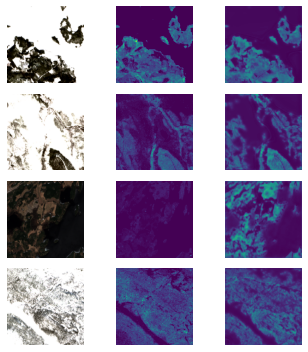

In [19]:
import torch 
import matplotlib.pyplot as plt 

dl = dm.train_dataloader(batch_size=4)
s1s, s2s, labels = next(iter(dl))

module.cpu()
preds = module.predict(s1s, s2s)

fig, ax = plt.subplots(4, 3, figsize=(5, 5))
for i in range(4):
	ax[i, 0].imshow(s2s[i][0][:3,...].permute(1, 2, 0))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(labels[i])
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
	# ax[i, 2].set_title(torch.sqrt(
    #         torch.mean((preds[i] - labels[i])**2)).item())
plt.tight_layout()
plt.show()

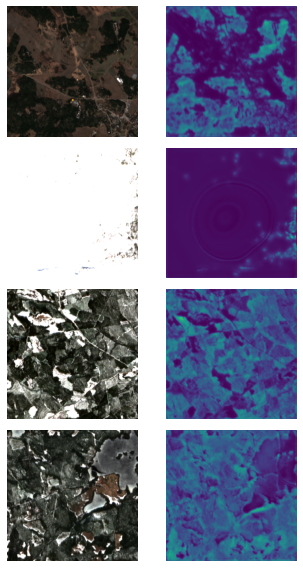

In [25]:
dl = dm.test_dataloader(batch_size=4)
s1s, s2s, _ = next(iter(dl))

module.cpu()
preds = module.predict(s1s, s2s)

fig, ax = plt.subplots(4, 2, figsize=(5, 8))
for i in range(4):
	ax[i, 0].imshow(s2s[i][0][:3,...].permute(1, 2, 0))
	ax[i, 0].axis('off')
	ax[i, 1].imshow(preds[i])
	ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

In [29]:
from tqdm import tqdm 
from skimage.io import imsave

dl = dm.test_dataloader(batch_size=16)

# si no tienes 2 gpus pon cuda(0)
module.cuda(1)

for s1s, s2s, chip_ids in tqdm(dl):
	s1s = s1s.cuda(1) if s1s is not None else None
	s2s = s2s.cuda(1) if s2s is not None else None
	preds = module.predict(s1s, s2s)
	# preds = preds*(dm.ds_test.max - dm.ds_test.min) + dm.ds_test.min
	# preds = preds*dm.ds_test.std + dm.ds_test.mean
	preds = preds*dm.ds_test.max
	for chip_id, pred in zip(chip_ids, preds.cpu().numpy()):
		imsave(f'./submission/{chip_id}_agbm.tif', pred)

100%|██████████| 174/174 [00:12<00:00, 13.62it/s]


In [30]:
import glob 

files = glob.glob('./submission/*.tif')
assert len(files) == 2773

In [31]:
# zip folder 

import shutil
shutil.make_archive('submission', 'zip', './submission')

'/home/juan/Desktop/competis/TheBioMassters/submission.zip'

In [32]:
import rasterio as rio
import numpy as np

ix = np.random.randint(0, len(files))
ds = rio.open(files[ix])

ds.indexes, ds.shape, ds.count

/home/juan/miniconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((1,), (256, 256), 1)

In [33]:
x = ds.read(1)

x.shape, x.dtype, x.min(), x.max()

((256, 256), dtype('float32'), 3.1401305, 389.36792)

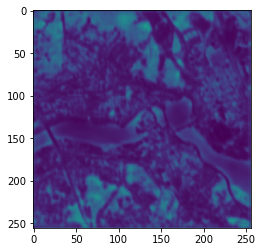

In [34]:
plt.imshow(x)
plt.show()